# Bateman-Burgers' Equation
Convection-diffusion PDE
$$
u_t + \epsilon u u_x = \mu u_{xx}
$$
where $\mu$ is a diffusion coefficient, $\epsilon$ is the advection coefficient, and $u(x, t)$ is the fluid speed.

We can use the Cole-Hopf transformation:
$$
\nu = \exp\left(-\frac{1}{2\mu}\int u\right) 
$$
To linearize the system to a simple heat equation in the new regime ($\epsilon = 1$):
$$
\nu_t = \mu\nu_{xx}
$$

## Initialization

We use the approximations, with $\Delta t = \tau$ and $\Delta x = h$:
$$
\begin{align}
\frac{\partial u}{\partial t} &= \frac{u_{x, t+\tau} - u_{x, t}}{\tau}\\
\frac{\partial u}{\partial x} &= \frac{u_{x+h, t} + u_{x-h, t}}{2h}\\
\frac{\partial ^2 u}{\partial x^2} &= \frac{u_{x+h, t}-2u_{x, t}+u_{x-h, t}}{h^2}
\end{align}
$$

$$
\frac{u_{x, t+\tau} + u_{x, t}}{\tau} = \mu \frac{u_{x+h, t}-2u_{x, t}+u_{x-h, t}}{h^2} - \epsilon u_{x,t}\frac{u_{x+h, t} + u_{x-h, t}}{2h}
$$

$$
u_{x, t+\tau} = \mu\tau \frac{u_{x+h, t}-2u_{x, t}+u_{x-h, t}}{h^2} - \epsilon u_{x,t}\tau\frac{u_{x+h, t} + u_{x-h, t}}{2h} - u_{x, t}
$$

$$
u_{x, t+\tau} = u_{x-h, t}\left[\frac{\mu\tau}{h^2}\right] + u_{x,t}u_{x+h,t}\left[\frac{\epsilon\tau}{2h}\right] + u_{x,t}u_{x-h,t}\left[\frac{\epsilon\tau}{2h}\right] + u_{x+h, t}\left[\frac{\mu\tau}{h^2}\right]
$$

It is not pure since there are interference terms.

I thus need to express it in terms of a higher order basis ?. If usually for linear PDEs this is a message passing scheme, would a topological network help for nonlinear PDEs?

A convinient basis would be ...

### Latin Sampling Test

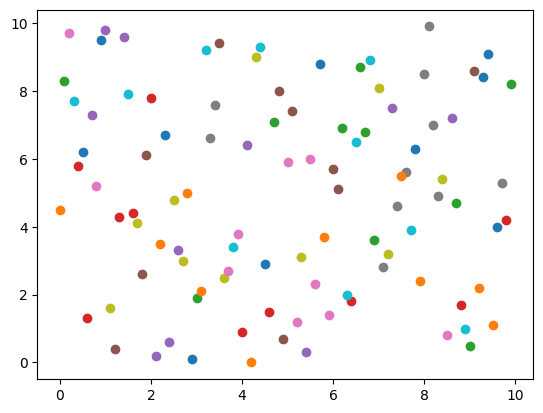

In [3]:
from latin_hypercube_sampling import *
from matplotlib import pyplot as plt
lhs = latin_hypercube_sampling(((0, 10), (0, 10)), 100)

for ye in lhs:
    plt.scatter(*ye)

### Single wave

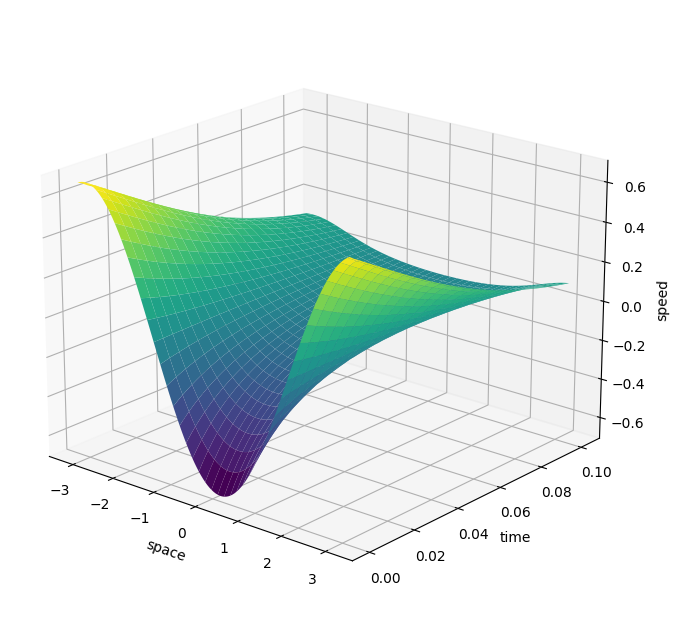

In [21]:
from burgers_data import *
from latin_hypercube_sampling import *
import numpy as np
from matplotlib import pyplot as plt

x = np.linspace(-np.pi, np.pi, 128)
t = np.linspace(0, .002*51, 51)
mu = .57
ep = 1
lhs_sampler = latin_hypercube_sampling(((0,1), (0,2*np.pi)), 100)

evol = evolve_burger(x, t, mu, ep, 'sine', lhs_sampler)

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(projection='3d')
X, T = np.meshgrid(x, t)
surf = ax.plot_surface(X, T, evol, cmap='viridis')

ax.set_xlabel('space')
ax.set_ylabel('time')
ax.set_zlabel('speed')
ax.view_init(elev=20, azim=-50)

plt.show()

### Wave grid

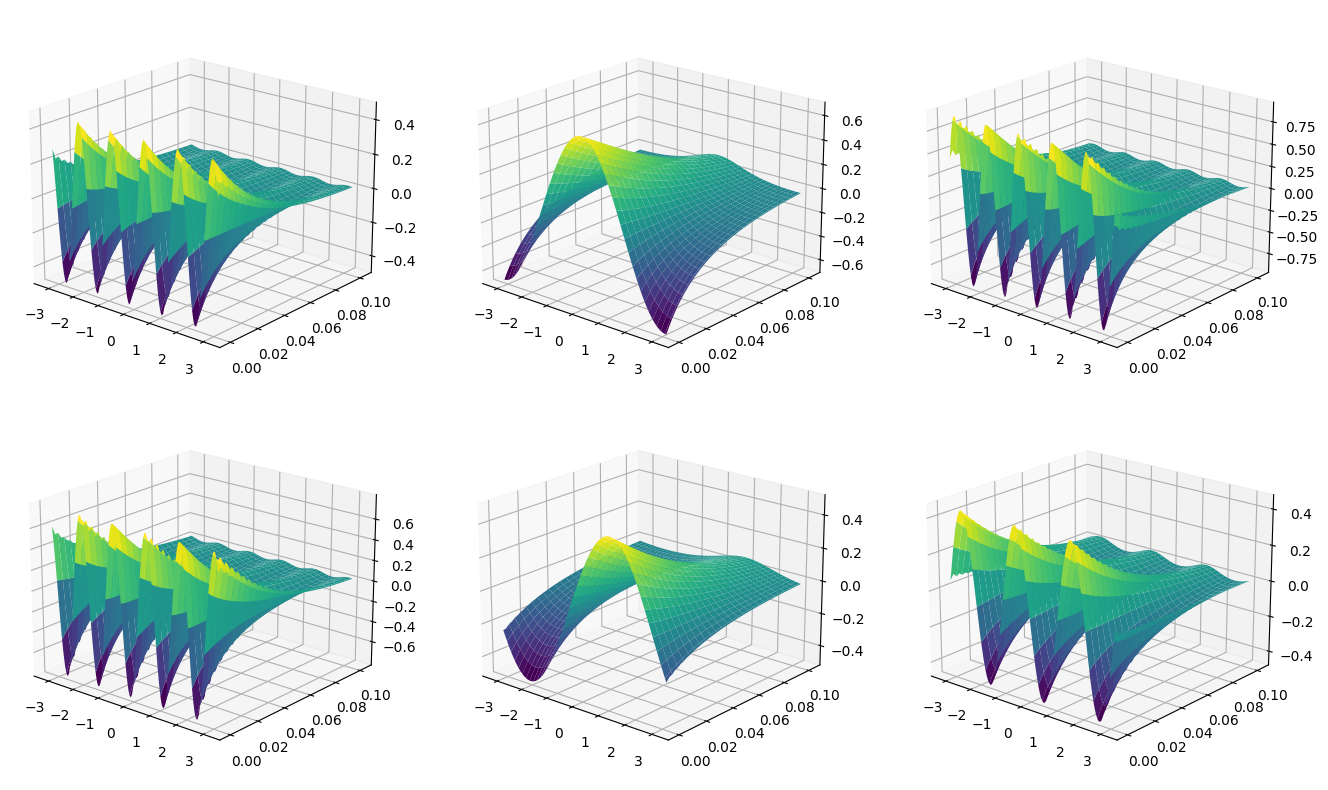

In [4]:
from burgers_data import *
from latin_hypercube_sampling import *
import numpy as np
from matplotlib import pyplot as plt
from itertools import product

x = np.linspace(-np.pi, np.pi, 128)
t = np.linspace(0, .002*51, 51)
mu = .57
ep = 1
lhs_sampler = latin_hypercube_sampling(((0,1), (0,2*np.pi)), 100)

nrows = 4
ncols = 12
fig, axes = plt.subplots(nrows, ncols, figsize = (12, 4), subplot_kw={'projection': '3d'})
X, T = np.meshgrid(x, t)

for i, j in product(range(nrows), range(ncols)):
    evol = evolve_burger(x, t, mu, ep, 'sine', lhs_sampler)
    surf = axes[i, j].plot_surface(X, T, evol, cmap='viridis')
    axes[i, j].view_init(elev=20, azim=-50)
    axes[i, j].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    axes[i, j].set_xticks([])
    axes[i, j].set_yticks([])
    axes[i, j].set_zticks([])

plt.tight_layout()
plt.show()

### Generate dataset

In [5]:
from burgers_data import *
dt = .002
time_steps = 50
angular_steps = 128
x = np.linspace(-np.pi, np.pi, angular_steps)
t = np.linspace(0, dt*(time_steps+1), (time_steps+1))
mu = .57
ep = 1
num_evols = 10000

state, target = build_dataset(x, t, mu, ep, num_evols)
state_data = tf.reshape(state, shape = (-1, angular_steps))
target_data = tf.reshape(target, shape = (-1, angular_steps))

data = tf.stack((state_data, target_data), axis = 0)
np.save('data.npy', data.numpy())

### Load dataset

In [6]:
import tensorflow as tf
data = tf.constant(np.load('data.npy'))
state_data = tf.constant(data[0])
target_data = tf.constant(data[1])

dataset = tf.data.Dataset.from_tensor_slices((state_data, target_data))

### Training

In [7]:
from PINN import *
epochs = 1
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.01)

burgers_koopman = PINN(oe_ls = [128,128,128,128], ie_ls = [128], ks = 128, id_ls = [128], od_ls = [128,128,128,128])
batch_size = 32
losses = training_loop(burgers_koopman, epochs, dataset, batch_size, optimizer)

tracing...


### Performance evaluation

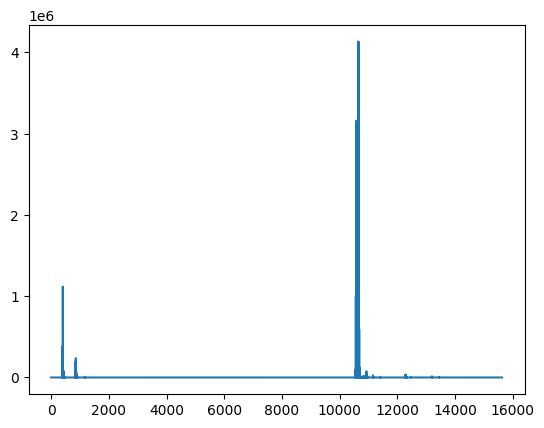

In [8]:
from matplotlib import pyplot as plt
#_losses = tf.reduce_mean(tf.reshape(losses, shape = (-1, 10)), axis = 1)
plt.plot(losses)

In [ ]:
initial_wave = dataset[np.where(shuffle_index.numpy()==0)[0][0], :, 0]
initial_wave = tf.reshape(initial_wave, shape = (1, len(initial_wave)))
max_steps = 51
evolution = np.zeros((max_steps, 128))
for step in range(max_steps):
    evolution[step, :] = burgers_koopman(initial_wave, step)

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(X, T, evolution, cmap='viridis')

ax.set_xlabel('space')
ax.set_ylabel('time')
ax.set_zlabel('speed')
ax.view_init(elev=20, azim=-50)

plt.show()

NameError: name 'dataset' is not defined